In [2]:
from os.path import join as pjoin
import numpy as np
import pandas as pd
import runpy
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import functions from other scripts
file_globals = runpy.run_path('digit_classification_knn.py')
get_digit_indices = file_globals['get_digit_indices']

In [16]:
"""YOUNG PROJECTION"""
with np.load('/media/predator/Avinash PhD/scripts/results_final/projections/old/projection_LOO_10-k_run2_union.npz', allow_pickle = True) as data:
    projected_data2 = data['projected_data']
    trained_srms2 = data['trained_srms']
proj_data_run1train = projected_data2
trained_srms_run1train = trained_srms2
# second run is training, first is test

with np.load('/media/predator/Avinash PhD/scripts/results_final/projections/old/projection_LOO_10-k_run1_union.npz', allow_pickle = True) as data:
    projected_data1 = data['projected_data']
    trained_srms1 = data['trained_srms']

proj_data_run2train = projected_data1
trained_srms_run2train = trained_srms1

In [17]:
# create finger-color arrays

# get ndarrays (nfingers, nvols)
digits_run1, digits_run2 = get_digit_indices()
#digits_run2=digits_run1###############################
# turn into flat arrays with values 1-5
digit_colors_run1, digit_colors_run2 = np.zeros(shape=(256)), np.zeros(shape=(256))
for finger_i in range(1,6):
    digit_colors_run1[digits_run1[finger_i-1]] = finger_i
    digit_colors_run2[digits_run2[finger_i-1]] = finger_i

# for some reason, the first entry in the first run's digit array is a 5, but should be a 1...
digit_colors_run1[0]=1.

In [18]:
# make lists of data frames

# first run is training, second is test
projected_dfs_run2 = []
trained_srms_dfs_run1 = []

for sub_idx in range(proj_data_run1train.shape[0]):
    df = pd.DataFrame(proj_data_run1train[sub_idx].T)
    projected_dfs_run2.append(df)
    srm_df = pd.DataFrame(trained_srms_run1train[sub_idx].T)
    trained_srms_dfs_run1.append(srm_df)

# second run is training, first is test
projected_dfs_run1 = []
trained_srms_dfs_run2 = []

for sub_idx in range(proj_data_run2train.shape[0]):
    df = pd.DataFrame(proj_data_run2train[sub_idx].T)
    projected_dfs_run1.append(df)
    srm_df = pd.DataFrame(trained_srms_run2train[sub_idx].T)
    trained_srms_dfs_run2.append(srm_df)

In [19]:
"""
Gather matrices for all subjects and save in big array
"""
# pick out number of dimensions and volumes
ndims, nvols = proj_data_run1train[0].shape

# set up results array
timepoint_distances = np.zeros(shape=(2, len(proj_data_run1train), nvols, nvols))

# iterate over runs and subjects
for run_idx, dataset in enumerate([proj_data_run1train, proj_data_run2train]):
    for sub_idx in range(len(proj_data_run1train)):

        for vol_i in range(nvols):
            for vol_j in range(nvols):
                dist = euclidean(dataset[sub_idx][:,vol_i],
                                 dataset[sub_idx][:,vol_j])
                timepoint_distances[run_idx, sub_idx, vol_i, vol_j] = dist

In [20]:
"""
Now average along subject and run axes
"""
av_timepoint_dist = np.average(timepoint_distances, axis=(0,1))
av_timepoint_dist.shape


(253, 253)

In [21]:
sns.set_context('talk')

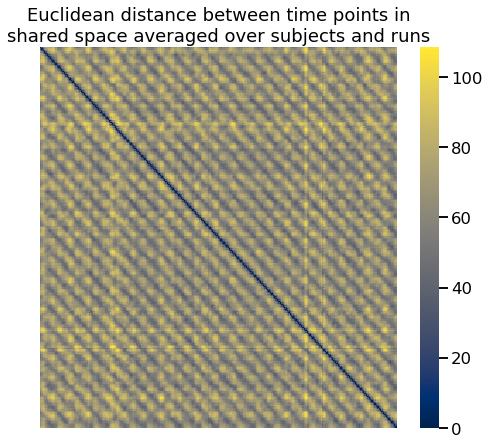

In [22]:
fig = plt.figure(figsize=(8,7))
axis = sns.heatmap(av_timepoint_dist, cbar=True, cmap='cividis')
plt.title("""Euclidean distance between time points in
shared space averaged over subjects and runs""")
axis.set_xticks([])
axis.set_yticks([])
fig.savefig('plots_young/tr_sim_heatm.png',dpi=300)
plt.show()

In [23]:
test_df = projected_dfs_run1[0]

In [24]:
# add correct digit labels for given run
test_df['digit'] = digit_colors_run1[:253]

In [25]:
# prepare results arrays
av_distances = np.zeros(shape=(2, len(projected_dfs_run1), 5 , 5))
std_distances = np.zeros(shape=(2, len(projected_dfs_run1), 5 , 5))

# iterate over runs and subjects
for run_idx in range(2):
    # select correct run and corresponding finger labels
    projected_dfs = [projected_dfs_run1, projected_dfs_run2][run_idx]
    digit_labels = [digit_colors_run1[:253], digit_colors_run2[:253]][run_idx]
    for sub_idx in range(len(projected_dfs_run1)):
        # select correct data frame and add digit labels for slicing
        df = projected_dfs[sub_idx]
        df['digit'] = digit_labels
        # iterate over pairs of digits
        for source_digit in range(1,6):
            for target_digit in range(1,6):
                # select subset of data frame for source and target digit (array of shape nsamples, nfeatures)
                source_data = df[df.digit == source_digit].drop(columns=['digit']).values
                target_data = df[df.digit == target_digit].drop(columns=['digit']).values
                # iterate over pairs of samples, compute distance, and save in list
                sample_wise_distances = []
                for source_sample in range(source_data.shape[0]):
                    for target_sample in range(target_data.shape[0]):
                        dist = euclidean(source_data[source_sample], target_data[target_sample])
                        sample_wise_distances.append(dist)
                # compute average and standard deviation of these distances
                av_distances[run_idx, sub_idx, source_digit-1, target_digit-1] = np.average(sample_wise_distances)
                std_distances[run_idx, sub_idx, source_digit-1, target_digit-1] = np.std(sample_wise_distances)
                                
                

In [26]:
"""
This shall basically be our final result for this matrix
"""

# aggregate (average) over subjects and runs
agg_av_distances_old = np.average(av_distances, axis=(0,1))
agg_std_distances_old = np.average(std_distances, axis=(0,1))

In [15]:
"""
This shall basically be our final result for this matrix
"""

# aggregate (average) over subjects and runs
agg_av_distances_young = np.average(av_distances, axis=(0,1))
agg_std_distances_young = np.average(std_distances, axis=(0,1))

In [76]:
matrix=agg_std_distances_old
diags = [matrix.diagonal(i)for i in range(5)]

In [77]:
diags

[array([22.19405327, 24.06616914, 23.3610483 , 24.03038591, 24.61059025]),
 array([23.7475906 , 24.30241867, 23.48336902, 24.17461086]),
 array([21.20167153, 22.40797861, 22.89236168]),
 array([21.05464075, 22.10689615]),
 array([23.46048674])]

In [82]:
np.mean(diags, axis=1)

IndexError: tuple index out of range

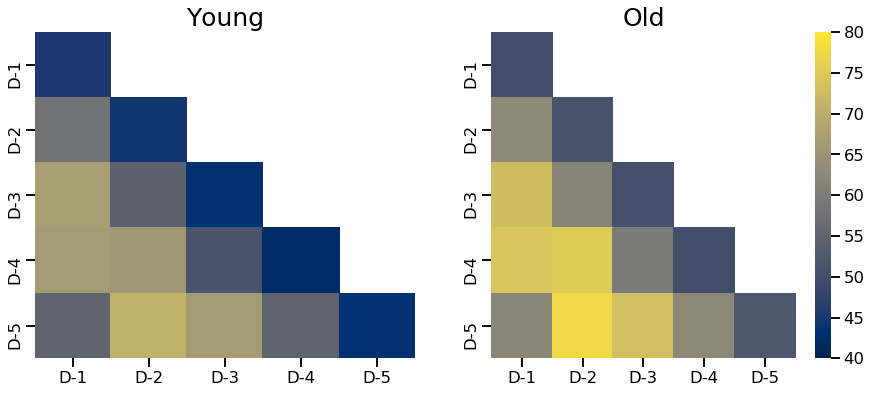

In [54]:
# mask lower triangle (because matrices are symmetric)
tril_mask = np.zeros_like(agg_av_distances, dtype=np.bool)
tril_mask[np.triu_indices_from(tril_mask, k=1)] = True

# start plotting
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

digit_strings = ['D-%i' %i for i in range(1,6)]
shared_figkws1 = {'cmap':'cividis', 'fmt':'.1f','vmin':40, 'vmax':80,'cbar':False,
                 'xticklabels':digit_strings, 'yticklabels':digit_strings, 'mask':tril_mask}
shared_figkws2 = {'cmap':'cividis', 'fmt':'.1f','vmin':40, 'vmax':80,'cbar':True,
                 'xticklabels':digit_strings, 'yticklabels':digit_strings, 'mask':tril_mask}

sns.heatmap(agg_av_distances_young, ax=axs[0], **shared_figkws1)

sns.heatmap(agg_av_distances_old, ax=axs[1], **shared_figkws2)

#supttl = plt.suptitle("""Digit-wise average euclidean distance between samples in shared space""",
#            )
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
axs[0].set_title('Young', fontsize=25)

axs[1].set_title('Old',fontsize=25)

fig.savefig('digit_sim_mean_p.png', bbox_inches='tight',bbox_extra_artists=[supttl], dpi=300)
plt.show() # ta-da!